In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import os
import json
import math

from pathlib import Path
import matplotlib.pyplot as plt
from typing import Any
from ray.tune import ExperimentAnalysis
from redis import Redis
import numpy as np
import pandas as pd
from pprint import pprint


rconn = Redis(password=os.environ["REDIS_PASSWORD"])
norm = np.linalg.norm
pd.set_option("display.max_rows", 500)

def deserialize(x: str) -> Any:
    return json.loads(x.replace("(", '[').replace(")", "]").replace("'", "\""))

In [3]:
#df = ExperimentAnalysis("~/ray_results/flight_tune_lqr_with_par_quad_cost").dataframe()
df = ExperimentAnalysis("~/ray_results/flight_tune_lqr_heading_1e4").dataframe()
print(df.keys())
print(df.shape)

Index(['objective', 'cost_list', 'hist_list', 'time_this_iter_s', 'done',
       'training_iteration', 'trial_id', 'date', 'timestamp', 'time_total_s',
       'pid', 'hostname', 'node_ip', 'time_since_restore',
       'iterations_since_restore', 'config/heading_cost', 'config/par_cost',
       'config/perp_cost', 'config/perp_quad_cost', 'logdir'],
      dtype='object')
(343, 20)


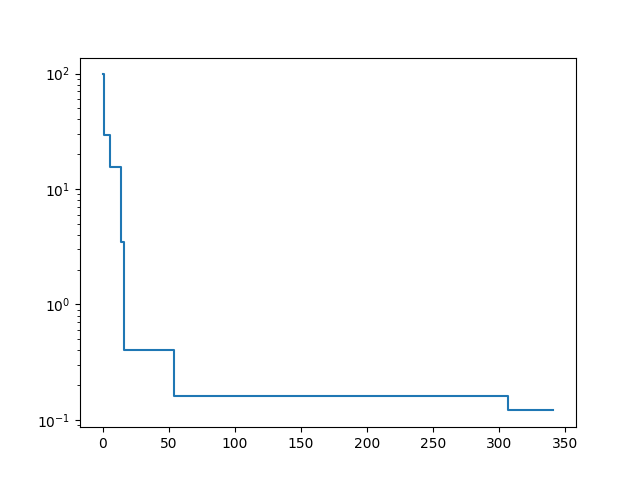

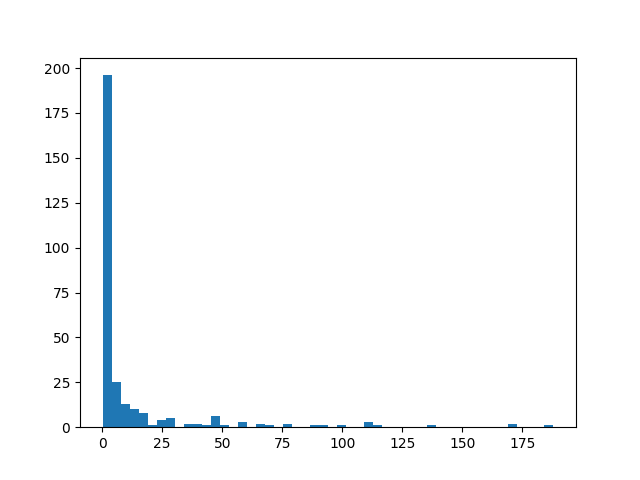

In [4]:
plt.figure()
plt.step(np.arange(df.shape[0] - 1), [np.min(df.sort_values("timestamp")["objective"][:i]) for i in range(1, df.shape[0])])
plt.yscale("log")
plt.show()
plt.figure()
objs = df.sort_values("timestamp")["objective"].to_numpy()
plt.hist(objs[objs < 1e7], bins=50)
plt.show()

In [8]:
top_k = 3
df.sort_values("objective").head(top_k)

,objective,cost_list,hist_list,time_this_iter_s,done,training_iteration,trial_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/heading_cost,config/par_cost,config/perp_cost,config/perp_quad_cost,logdir
240,0.120433,"[0.12043262475357337, 0.12043262475357337, 0.0]","[{""offset"": [0.0, 0.0], ""hist"": {""x"": [[2781.1...",125.098509,False,1,afc54a06,2023-06-03_05-30-40,1685795440,125.098509,26005,DESKTOPRD,192.168.1.190,125.098509,1,10000.0,498.863996,481.605499,0.002698,/home/rdyro/ray_results/flight_tune_lqr_headin...
252,0.159304,"[0.15930377570201845, 0.038880540223115545, 0.0]","[{""offset"": [0.0, 0.0], ""hist"": {""x"": [[2781.9...",126.862875,False,1,b93f26c4,2023-06-02_20-59-37,1685764777,126.862875,26005,DESKTOPRD,192.168.1.190,126.862875,1,10000.0,523.796078,481.605499,0.002994,/home/rdyro/ray_results/flight_tune_lqr_headin...
85,0.279762,"[0.2797622844063771, 0.24076359467312994, 0.15...","[{""offset"": [0.0, 0.0], ""hist"": {""x"": [[2781.1...",124.134260,False,1,43a0b4b3,2023-06-02_23-36-53,1685774213,124.134260,26005,DESKTOPRD,192.168.1.190,124.134260,1,10000.0,410.522396,481.605499,0.001125,/home/rdyro/ray_results/flight_tune_lqr_headin...


In [9]:
df.sort_values("objective").head(top_k)["config"]

KeyError: 'config'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


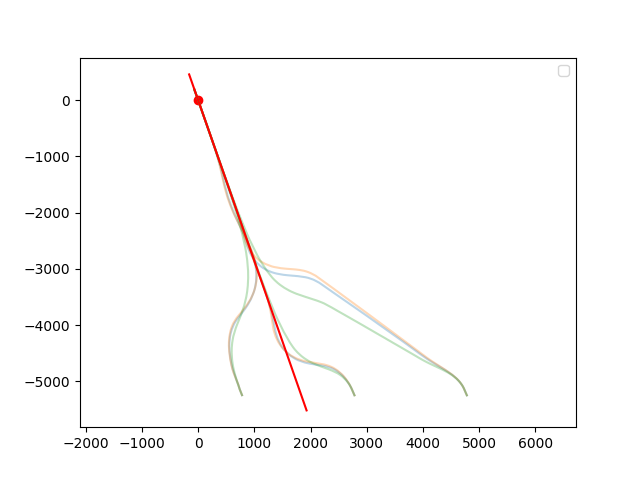

In [7]:
hists = df.sort_values("objective").head(top_k)["hist_list"].apply(deserialize)
approach_ang = 2.05705199 - 0.15
plt.figure()
for (i, hist_list) in enumerate(hists):
    for hist in hist_list:
        x = np.array(hist["hist"]["x"])
        plt.plot(x[:, 0], x[:, 1], alpha=0.3, color=f"C{i}")
xlim, ylim = plt.xlim(), plt.ylim()
x = np.linspace(-1e4, 1e4, 10 ** 4)
y = np.tan(approach_ang) * x
mask = (x > xlim[0]) & (x < xlim[1]) & (y > ylim[0]) & (y < ylim[1])
x, y = x[mask], y[mask]
plt.scatter(0, 0, color="red")
plt.plot(x, y, color="red")
plt.legend()
plt.axis("equal")
plt.show()

# Older tuning

In [13]:
df = ExperimentAnalysis("~/ray_results/flight_tune_lqr2").dataframe()
print(df.keys())

Index(['objective', 'cost_list', 'hist_list', 'time_this_iter_s', 'done',
       'training_iteration', 'trial_id', 'date', 'timestamp', 'time_total_s',
       'pid', 'hostname', 'node_ip', 'time_since_restore',
       'iterations_since_restore', 'config/par_cost', 'config/perp_cost',
       'config/perp_quad_cost', 'logdir'],
      dtype='object')


In [15]:
target = np.zeros(2)
approach_ang = 2.05705199 - 0.15


def custom_cost_fn(hist_list):
    hist_list = [x["hist"] for x in deserialize(hist_list)]
    cost = -math.inf
    for hist in hist_list:
        x = np.array(hist["x"])
        idx = np.argmin(np.linalg.norm(x[:, :2] - target, axis=1))
        cost = np.maximum(np.linalg.norm(x[idx, :2] - target), cost)
    return cost


costs = [
    custom_cost_fn(row["hist_list"]) if isinstance(row["hist_list"], str) else math.inf
    for (i, row) in df.iterrows()
]
hists = df.iloc[np.argsort(costs)[:3]]["hist_list"].apply(deserialize).values


In [20]:
df2 = df.iloc[np.argsort(costs)[:3]]
df2["cost"] = df2["hist_list"].apply(custom_cost_fn)
df2[[k for k in df.columns if "config" in k] + ["objective", "cost"]]

/tmp/ipykernel_1495661/2166660867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["cost"] = df2["hist_list"].apply(custom_cost_fn)


,config/par_cost,config/perp_cost,config/perp_quad_cost,objective,cost
143,67.921879,529.419709,0.001494,4.972007e+06,64.886895
237,120.929367,353.854775,0.002131,4.597723e+06,77.936838
21,70.124013,481.605499,0.001356,4.882710e+06,79.383927


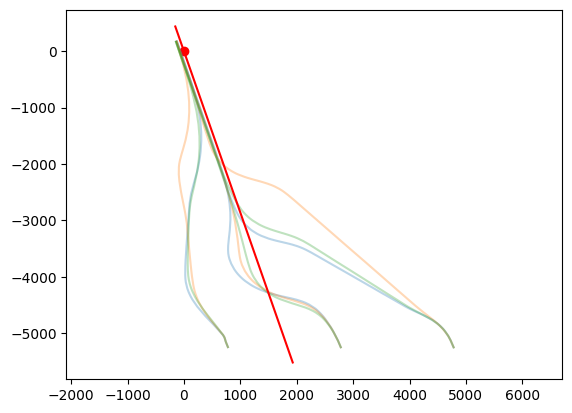

In [6]:
approach_ang = 2.05705199 - 0.15
plt.figure()
for (i, hist_list) in enumerate(hists):
    for hist in hist_list:
        x = np.array(hist["hist"]["x"])
        plt.plot(x[:, 0], x[:, 1], alpha=0.3, color=f"C{i}")
xlim, ylim = plt.xlim(), plt.ylim()
x = np.linspace(-1e4, 1e4, 10 ** 4)
y = np.tan(approach_ang) * x
mask = (x > xlim[0]) & (x < xlim[1]) & (y > ylim[0]) & (y < ylim[1])
x, y = x[mask], y[mask]
plt.scatter(0, 0, color="red")
plt.plot(x, y, color="red")
plt.axis("equal")
plt.show()

In [27]:
target = np.zeros(2)
approach_ang = 2.05705199 - 0.15

def cost(x, target=target, approach_ang=approach_ang):
    v_norm = np.array([np.cos(approach_ang), np.sin(approach_ang)])
    v_par = np.dot(target - x, v_norm)[..., None] * v_norm
    v_perp = (target - x) - v_par
    return np.mean(norm(v_perp, axis=-1))

In [36]:
costs = [cost(np.array(z["hist"]["x"])[:, :2]) for z in data]
data = [data[idx] for idx in np.argsort(costs)]

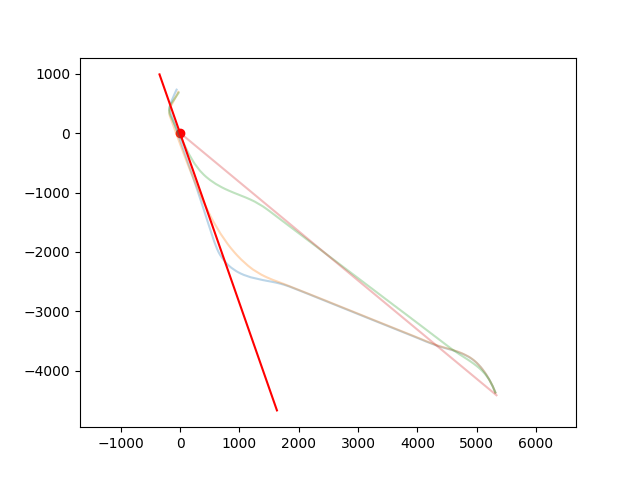

In [38]:
approach_ang = 2.05705199 - 0.15
plt.figure()
for (i, trial) in enumerate(data):
    config = trial["config"]
    hist = trial["hist"]
    x = np.array(hist["x"])
    idx = np.argmin(norm(x[:, :2] - np.zeros(2), axis=-1))
    if norm(x[idx, :2] - np.zeros(2)) > 100:
        continue
    if x[idx, 2] > 100:
        continue
    plt.plot(x[:, 0], x[:, 1], alpha=0.3)
xlim, ylim = plt.xlim(), plt.ylim()
x = np.linspace(-1e4, 1e4, 10 ** 4)
y = np.tan(approach_ang) * x
mask = (x > xlim[0]) & (x < xlim[1]) & (y > ylim[0]) & (y < ylim[1])
x, y = x[mask], y[mask]
plt.scatter(0, 0, color="red")
plt.plot(x, y, color="red")
plt.axis("equal")
plt.show()

In [41]:
data[i]["config"]

{'perp_cost': 3162.2776601683795, 'perp_quad_cost': 0.0001244795587027246}